# Imports

In [59]:
import os
import glob
import shutil
from collections import Counter

import plotly.express as px
import plotly.graph_objects as go
import matplotlib.pyplot as plt

import numpy as np
from tqdm import tqdm

import sklearn.metrics

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from torch.utils.data.sampler import WeightedRandomSampler
from torchvision import transforms
from torchvision.utils import save_image
import torchvision

In [64]:
CORE_PATH = "/content/drive/MyDrive/data"
ORIG_PATH = "/content/drive/MyDrive/data/emotions_orig"
TO_LOAD_PATH = "/content/drive/MyDrive/data/emotions_load"
SAVE_PATH = "/content/drive/MyDrive/data/emotions_tmp_results"

# EDA

In [3]:
emotions = os.listdir(ORIG_PATH)
emotions

['fear', 'sadness', 'disgust', 'contempt', 'anger', 'joy', 'wonder']

In [ ]:
primary_distribution = {x: 0 for x in emotions}

for emote in emotions:
    files = [f for f in os.listdir(f"{ORIG_PATH}/{emote}/")]
    primary_distribution[emote] = len(files)

fig = go.Figure(
    go.Bar(x=list(primary_distribution.keys()),
           y=list(primary_distribution.values())),
)
fig.update_layout(
    width=600,
    height=400,
    title="Number of images"
)
fig.show(renderer="colab")

In [ ]:
sum(primary_distribution.values())

496

# Data Splitting

In [ ]:
np.random.seed(2024)
test_size = .1

train_samples = {}
test_samples = {}

for emote in emotions:
    for dirpath, _, filenames in os.walk(f"{ORIG_PATH}/{emote}"):
        files = [os.path.abspath(os.path.join(dirpath, f)) for f in filenames]

    np.random.shuffle(files)
    test_num = int(len(files) * test_size)

    train_samples[emote] = files[:-test_num]
    test_samples[emote] = files[-test_num:]

In [ ]:
for emote in emotions:
    os.makedirs(f"{TO_LOAD_PATH}/train/{emote}")
    os.makedirs(f"{TO_LOAD_PATH}/test/{emote}")

    for train_file in train_samples[emote]:
        shutil.copy(train_file, f"{TO_LOAD_PATH}/train/{emote}")
    for test_file in test_samples[emote]:
        shutil.copy(test_file, f"{TO_LOAD_PATH}/test/{emote}")

# Data balancing and loading

In [4]:
train_transforms = transforms.Compose([transforms.RandomRotation(30),
                                       transforms.RandomResizedCrop(224),
                                       transforms.RandomGrayscale(),
                                       transforms.RandomHorizontalFlip(),
                                       transforms.ToTensor(),
                                       transforms.Normalize([0.485, 0.456, 0.406],
                                                            [0.229, 0.224, 0.225])])

inf_transforms = transforms.Compose([transforms.Resize(224),
                                     transforms.CenterCrop(224),
                                     transforms.ToTensor(),
                                     transforms.Normalize([0.485, 0.456, 0.406],
                                                          [0.229, 0.224, 0.225])])

train = torchvision.datasets.ImageFolder(
    f"{TO_LOAD_PATH}/train",
    transform=train_transforms
)
test = torchvision.datasets.ImageFolder(
    f"{TO_LOAD_PATH}/test",
    transform=inf_transforms
)

In [5]:
len(train) + len(test)

496

In [19]:
class_to_index = train.class_to_idx
index_to_class = {v: k for k, v in class_to_index.items()}

class_to_index, index_to_class

({'anger': 0,
  'contempt': 1,
  'disgust': 2,
  'fear': 3,
  'joy': 4,
  'sadness': 5,
  'wonder': 6},
 {0: 'anger',
  1: 'contempt',
  2: 'disgust',
  3: 'fear',
  4: 'joy',
  5: 'sadness',
  6: 'wonder'})

In [ ]:
def get_loader(image_folder, BATCH_SIZE):
    distrib = Counter(image_folder.targets)
    class_weights = {x: len(image_folder) / distrib[x] for x in distrib.keys()}
    sample_weights = [class_weights[x] for x in image_folder.targets]
    sampler = WeightedRandomSampler(sample_weights, len(sample_weights))

    return DataLoader(image_folder, BATCH_SIZE, sampler=sampler)

In [ ]:
train_loader = get_loader(train, 16)
test_loader = get_loader(test, 16)

# Utility functions

In [ ]:
def train_model(model, train_loader, val_loader, epochs, criterion, optimizer, device):
    model.to(device)
    train_loss = []
    val_loss = []
    train_batch_accuracy = []
    val_batch_accuracy = []

    for step, epoch in enumerate(range(epochs)):
        loss_per_batch = 0.0

        model.train()
        for image, label in tqdm(train_loader):
            optimizer.zero_grad()
            image, label = image.to(device), label.to(device)

            output = model(image)
            output_pred = output.max(1)[1].data
            loss = criterion(output, label)
            loss.backward()
            optimizer.step()

            loss_per_batch += loss.item() * output.shape[0]
            train_batch_accuracy.append(np.mean((label.cpu() == output_pred.cpu()).numpy() ))

        train_loss.append(loss_per_batch / len(train_loader.dataset))

        print(f"EPOCH: {step + 1}, train_loss: {train_loss[step]}, train_acc: {np.mean(train_batch_accuracy)}")
        print()

In [ ]:
def test_model(model, test_loader, device):
    model.eval()
    test_batch_acc = []
    for X_batch, y_batch in tqdm(test_loader):
        logits = model(X_batch.to(device))
        y_pred = logits.max(1)[1].data
        test_batch_acc.append(np.mean((y_batch.cpu() == y_pred.cpu()).numpy()))

    test_accuracy = np.mean(test_batch_acc)
    print(f"Test accuracy:\t\t{test_accuracy * 100:.2f} %")

In [7]:
def inference_model(model, folder, device):
    data = torchvision.datasets.ImageFolder(
        folder,
        transform=inf_transforms
    )
    model.to(device)
    model.eval()

    true = []
    pred = []
    for image, label in data:
        logits = model(image.to(device).unsqueeze(0))

        pred.append(logits.max(1)[1].data.cpu().item())
        true.append(label)

    return true, pred

In [8]:
# source: https://www.kaggle.com/code/nkitgupta/evaluation-metrics-for-multi-class-classification
def roc_auc_score_multiclass(actual_class, pred_class, average = "macro"):
    unique_class = set(actual_class)
    roc_auc_dict = {}
    for per_class in unique_class:
        other_class = [x for x in unique_class if x != per_class]
        new_actual_class = [0 if x in other_class else 1 for x in actual_class]
        new_pred_class = [0 if x in other_class else 1 for x in pred_class]
        roc_auc = sklearn.metrics.roc_auc_score(new_actual_class, new_pred_class, average = average)
        roc_auc_dict[per_class] = roc_auc

    return roc_auc_dict

def get_metrics_report(true, pred):
    return {
        "Accuracy": sklearn.metrics.accuracy_score(true, pred),
        "Precision_macro": sklearn.metrics.precision_score(true, pred, average='macro'),
        "Precision_micro": sklearn.metrics.precision_score(true, pred, average='micro'),
        "Recall_macro": sklearn.metrics.recall_score(true, pred, average='macro'),
        "Recall_micro": sklearn.metrics.recall_score(true, pred, average='micro'),
        "ROC_AUC": roc_auc_score_multiclass(true, pred)
    }

In [42]:
def get_classification_report(true, pred):
    t, p = np.array(true), np.array(pred)
    for _class in set(t):
        indices_class = np.where(t == _class)[0]
        correct = t[indices_class]
        predicted = p[indices_class]

        print(f"{index_to_class[_class]} emotion")
        print(f"Overall images: {len(indices_class)}")
        print(f"Correctly predicted {(correct == predicted).sum()}/{len(indices_class)}")
        print()

In [65]:
def get_mistaken_images_report(folder, pred):
    data = torchvision.datasets.ImageFolder(folder, transform=inf_transforms)
    for ind, (image, label) in enumerate(data):
        if label == pred[ind]:
            continue

        plt.title(f"True: {index_to_class[label]}, Predicted: {index_to_class[pred[ind]]}")
        plt.imshow(image.permute(1, 2, 0))
        plt.savefig(f'{SAVE_PATH}/image_{ind}.png')
        plt.show()

# RESNET

In [12]:
from torchvision.models import resnet50, ResNet50_Weights

In [13]:
model = resnet50(weights=ResNet50_Weights.DEFAULT)

for name, param in model.named_parameters():
    param.requires_grad = False

classifier = nn.Sequential(nn.Linear(model.fc.in_features, 512),
                            nn.ReLU(),
                            nn.Dropout(),
                            nn.Linear(512, len(emotions)))
model.fc = classifier

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 159MB/s]


In [14]:
EPOCHS = 100

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

In [ ]:
train_model(model, train_loader, test_loader, EPOCHS, criterion, optimizer, device)

100%|██████████| 29/29 [00:12<00:00,  2.24it/s]


EPOCH: 1, train_loss: 1.918154629938852, train_acc: 0.22198275862068967



100%|██████████| 29/29 [00:12<00:00,  2.40it/s]


EPOCH: 2, train_loss: 1.8311815458310474, train_acc: 0.24676724137931033



100%|██████████| 29/29 [00:12<00:00,  2.33it/s]


EPOCH: 3, train_loss: 1.6845863067227642, train_acc: 0.28879310344827586



100%|██████████| 29/29 [00:12<00:00,  2.25it/s]


EPOCH: 4, train_loss: 1.671377513350251, train_acc: 0.30064655172413796



100%|██████████| 29/29 [00:11<00:00,  2.59it/s]


EPOCH: 5, train_loss: 1.629230269344984, train_acc: 0.30775862068965515



100%|██████████| 29/29 [00:13<00:00,  2.21it/s]


EPOCH: 6, train_loss: 1.5979512136072784, train_acc: 0.3193247126436782



100%|██████████| 29/29 [00:13<00:00,  2.18it/s]


EPOCH: 7, train_loss: 1.491660610604658, train_acc: 0.33866995073891626



100%|██████████| 29/29 [00:13<00:00,  2.18it/s]


EPOCH: 8, train_loss: 1.5740688712665922, train_acc: 0.34401939655172414



100%|██████████| 29/29 [00:11<00:00,  2.59it/s]


EPOCH: 9, train_loss: 1.4821721549023499, train_acc: 0.35368773946360155



100%|██████████| 29/29 [00:14<00:00,  2.03it/s]


EPOCH: 10, train_loss: 1.5063315574204206, train_acc: 0.3586206896551724



100%|██████████| 29/29 [00:11<00:00,  2.59it/s]


EPOCH: 11, train_loss: 1.4693958626558095, train_acc: 0.3667711598746082



100%|██████████| 29/29 [00:12<00:00,  2.33it/s]


EPOCH: 12, train_loss: 1.4511389695190906, train_acc: 0.3730244252873563



100%|██████████| 29/29 [00:14<00:00,  2.07it/s]


EPOCH: 13, train_loss: 1.3686603236039125, train_acc: 0.3788129973474801



100%|██████████| 29/29 [00:12<00:00,  2.32it/s]


EPOCH: 14, train_loss: 1.3652713476682294, train_acc: 0.38808497536945813



100%|██████████| 29/29 [00:11<00:00,  2.50it/s]


EPOCH: 15, train_loss: 1.2990299564161916, train_acc: 0.39727011494252873



100%|██████████| 29/29 [00:13<00:00,  2.17it/s]


EPOCH: 16, train_loss: 1.2430716091912148, train_acc: 0.4035560344827586



100%|██████████| 29/29 [00:12<00:00,  2.27it/s]


EPOCH: 17, train_loss: 1.2576077743734178, train_acc: 0.40998985801217036



100%|██████████| 29/29 [00:12<00:00,  2.41it/s]


EPOCH: 18, train_loss: 1.2404482343414578, train_acc: 0.41678639846743293



100%|██████████| 29/29 [00:12<00:00,  2.39it/s]


EPOCH: 19, train_loss: 1.261034160520558, train_acc: 0.42150635208711434



100%|██████████| 29/29 [00:11<00:00,  2.50it/s]


EPOCH: 20, train_loss: 1.3469934771480432, train_acc: 0.425323275862069



100%|██████████| 29/29 [00:12<00:00,  2.33it/s]


EPOCH: 21, train_loss: 1.222911191145933, train_acc: 0.4317528735632184



100%|██████████| 29/29 [00:13<00:00,  2.13it/s]


EPOCH: 22, train_loss: 1.2020640840509156, train_acc: 0.4358346394984326



100%|██████████| 29/29 [00:11<00:00,  2.49it/s]


EPOCH: 23, train_loss: 1.2355536787971888, train_acc: 0.4376874062968516



100%|██████████| 29/29 [00:12<00:00,  2.37it/s]


EPOCH: 24, train_loss: 1.2319717537321333, train_acc: 0.4418103448275862



100%|██████████| 29/29 [00:13<00:00,  2.14it/s]


EPOCH: 25, train_loss: 1.1783130484859237, train_acc: 0.4446551724137931



100%|██████████| 29/29 [00:12<00:00,  2.32it/s]


EPOCH: 26, train_loss: 1.1538879483739093, train_acc: 0.4495192307692308



100%|██████████| 29/29 [00:12<00:00,  2.38it/s]


EPOCH: 27, train_loss: 1.1459300650785655, train_acc: 0.4528256704980843



100%|██████████| 29/29 [00:13<00:00,  2.13it/s]


EPOCH: 28, train_loss: 1.159067603155871, train_acc: 0.45635775862068967



100%|██████████| 29/29 [00:12<00:00,  2.38it/s]


EPOCH: 29, train_loss: 1.1271531709318436, train_acc: 0.46076099881093935



100%|██████████| 29/29 [00:11<00:00,  2.43it/s]


EPOCH: 30, train_loss: 1.1055849357808885, train_acc: 0.46551724137931033



100%|██████████| 29/29 [00:13<00:00,  2.09it/s]


EPOCH: 31, train_loss: 1.0911309889005394, train_acc: 0.4698971078976641



100%|██████████| 29/29 [00:11<00:00,  2.53it/s]


EPOCH: 32, train_loss: 1.0954914889516172, train_acc: 0.47346443965517243



100%|██████████| 29/29 [00:11<00:00,  2.56it/s]


EPOCH: 33, train_loss: 1.091951483342058, train_acc: 0.4766849529780564



100%|██████████| 29/29 [00:11<00:00,  2.47it/s]


EPOCH: 34, train_loss: 1.1649947208922795, train_acc: 0.47996957403651114



100%|██████████| 29/29 [00:14<00:00,  2.05it/s]


EPOCH: 35, train_loss: 1.0047716765201968, train_acc: 0.483743842364532



100%|██████████| 29/29 [00:12<00:00,  2.24it/s]


EPOCH: 36, train_loss: 1.0891595449638791, train_acc: 0.4870689655172414



100%|██████████| 29/29 [00:11<00:00,  2.45it/s]


EPOCH: 37, train_loss: 1.0064120213013714, train_acc: 0.48986486486486486



100%|██████████| 29/29 [00:13<00:00,  2.17it/s]


EPOCH: 38, train_loss: 1.023910686539648, train_acc: 0.49245689655172414



100%|██████████| 29/29 [00:12<00:00,  2.37it/s]


EPOCH: 39, train_loss: 1.083285473502824, train_acc: 0.4938107869142352



100%|██████████| 29/29 [00:12<00:00,  2.24it/s]


EPOCH: 40, train_loss: 1.075500687140399, train_acc: 0.49682112068965517



100%|██████████| 29/29 [00:13<00:00,  2.18it/s]


EPOCH: 41, train_loss: 0.9962876302362285, train_acc: 0.49915895710681246



100%|██████████| 29/29 [00:12<00:00,  2.35it/s]


EPOCH: 42, train_loss: 1.0882330843494306, train_acc: 0.5011802134646962



100%|██████████| 29/29 [00:13<00:00,  2.14it/s]


EPOCH: 43, train_loss: 1.0223848230323707, train_acc: 0.5035084202085004



100%|██████████| 29/29 [00:13<00:00,  2.18it/s]


EPOCH: 44, train_loss: 0.9854420325272863, train_acc: 0.5060246865203761



100%|██████████| 29/29 [00:12<00:00,  2.30it/s]


EPOCH: 45, train_loss: 0.9987882654491671, train_acc: 0.5083333333333333



100%|██████████| 29/29 [00:13<00:00,  2.17it/s]


EPOCH: 46, train_loss: 1.0096679795823809, train_acc: 0.5102136431784108



100%|██████████| 29/29 [00:11<00:00,  2.53it/s]


EPOCH: 47, train_loss: 1.0438120492582597, train_acc: 0.5119222303741746



100%|██████████| 29/29 [00:13<00:00,  2.23it/s]


EPOCH: 48, train_loss: 1.0011192244251481, train_acc: 0.5142331178160919



100%|██████████| 29/29 [00:13<00:00,  2.18it/s]


EPOCH: 49, train_loss: 1.0259624297475496, train_acc: 0.5162297677691766



100%|██████████| 29/29 [00:12<00:00,  2.27it/s]


EPOCH: 50, train_loss: 0.9463482981004269, train_acc: 0.5186206896551724



100%|██████████| 29/29 [00:12<00:00,  2.30it/s]


EPOCH: 51, train_loss: 1.0034602171594156, train_acc: 0.5208333333333334



100%|██████████| 29/29 [00:13<00:00,  2.21it/s]


EPOCH: 52, train_loss: 0.9806302613298717, train_acc: 0.5221734084880637



100%|██████████| 29/29 [00:13<00:00,  2.21it/s]


EPOCH: 53, train_loss: 1.023010924027067, train_acc: 0.5233409238776838



100%|██████████| 29/29 [00:10<00:00,  2.65it/s]


EPOCH: 54, train_loss: 0.9689423862703659, train_acc: 0.5244651979565773



100%|██████████| 29/29 [00:13<00:00,  2.21it/s]


EPOCH: 55, train_loss: 1.0250458773101092, train_acc: 0.5255094043887147



100%|██████████| 29/29 [00:12<00:00,  2.33it/s]


EPOCH: 56, train_loss: 1.0025747135646625, train_acc: 0.5267472290640394



100%|██████████| 29/29 [00:11<00:00,  2.50it/s]


EPOCH: 57, train_loss: 1.0349301702461158, train_acc: 0.5271854204476709



100%|██████████| 29/29 [00:12<00:00,  2.30it/s]


EPOCH: 58, train_loss: 0.9297866643404377, train_acc: 0.5289833531510107



100%|██████████| 29/29 [00:12<00:00,  2.32it/s]


EPOCH: 59, train_loss: 0.910037556310539, train_acc: 0.5314509059029807



100%|██████████| 29/29 [00:13<00:00,  2.17it/s]


EPOCH: 60, train_loss: 1.011890180392361, train_acc: 0.5321479885057471



100%|██████████| 29/29 [00:13<00:00,  2.21it/s]


EPOCH: 61, train_loss: 0.9553585684379119, train_acc: 0.5342707744488412



100%|██████████| 29/29 [00:11<00:00,  2.51it/s]


EPOCH: 62, train_loss: 0.8931380316515543, train_acc: 0.5356993882091212



100%|██████████| 29/29 [00:12<00:00,  2.28it/s]


EPOCH: 63, train_loss: 0.8714224424022343, train_acc: 0.5375273672687466



100%|██████████| 29/29 [00:13<00:00,  2.21it/s]


EPOCH: 64, train_loss: 0.8730261442655975, train_acc: 0.5391635237068966



100%|██████████| 29/29 [00:12<00:00,  2.33it/s]


EPOCH: 65, train_loss: 0.8546184192521535, train_acc: 0.5411472148541114



100%|██████████| 29/29 [00:13<00:00,  2.12it/s]


EPOCH: 66, train_loss: 0.930585872357035, train_acc: 0.5425156739811913



100%|██████████| 29/29 [00:12<00:00,  2.27it/s]


EPOCH: 67, train_loss: 0.8601721134907949, train_acc: 0.544486618630983



100%|██████████| 29/29 [00:12<00:00,  2.36it/s]


EPOCH: 68, train_loss: 0.8906321177769344, train_acc: 0.5462728194726166



100%|██████████| 29/29 [00:12<00:00,  2.32it/s]


EPOCH: 69, train_loss: 0.9690604924093642, train_acc: 0.5473825587206397



100%|██████████| 29/29 [00:13<00:00,  2.21it/s]


EPOCH: 70, train_loss: 0.9258510455787846, train_acc: 0.5483374384236454



100%|██████████| 29/29 [00:12<00:00,  2.38it/s]


EPOCH: 71, train_loss: 0.876907810601997, train_acc: 0.5494779018941234



100%|██████████| 29/29 [00:11<00:00,  2.51it/s]


EPOCH: 72, train_loss: 0.888255009672424, train_acc: 0.5507962164750958



100%|██████████| 29/29 [00:14<00:00,  1.95it/s]


EPOCH: 73, train_loss: 0.9074074499856656, train_acc: 0.5519012753897025



100%|██████████| 29/29 [00:11<00:00,  2.46it/s]


EPOCH: 74, train_loss: 0.7971062325687875, train_acc: 0.5538210624417521



100%|██████████| 29/29 [00:12<00:00,  2.39it/s]


EPOCH: 75, train_loss: 0.8726324484183687, train_acc: 0.5556609195402299



100%|██████████| 29/29 [00:14<00:00,  2.03it/s]


EPOCH: 76, train_loss: 0.8164060837972934, train_acc: 0.5571404264972777



100%|██████████| 29/29 [00:12<00:00,  2.33it/s]


EPOCH: 77, train_loss: 0.8690971207778013, train_acc: 0.5584975369458128



100%|██████████| 29/29 [00:11<00:00,  2.46it/s]


EPOCH: 78, train_loss: 0.8257393890075004, train_acc: 0.5598751105216623



100%|██████████| 29/29 [00:13<00:00,  2.15it/s]


EPOCH: 79, train_loss: 0.9058978886806088, train_acc: 0.5612723701440419



100%|██████████| 29/29 [00:12<00:00,  2.37it/s]


EPOCH: 80, train_loss: 0.8356050900733285, train_acc: 0.5624730603448276



100%|██████████| 29/29 [00:11<00:00,  2.60it/s]


EPOCH: 81, train_loss: 0.7837102614957134, train_acc: 0.5639367816091954



100%|██████████| 29/29 [00:13<00:00,  2.13it/s]


EPOCH: 82, train_loss: 0.7797413942277565, train_acc: 0.5656801934398654



100%|██████████| 29/29 [00:12<00:00,  2.32it/s]


EPOCH: 83, train_loss: 0.8678762880890301, train_acc: 0.5666026173660158



100%|██████████| 29/29 [00:12<00:00,  2.24it/s]


EPOCH: 84, train_loss: 0.8756646807315885, train_acc: 0.5676826765188834



100%|██████████| 29/29 [00:12<00:00,  2.29it/s]


EPOCH: 85, train_loss: 0.8443918299834288, train_acc: 0.5694979716024341



100%|██████████| 29/29 [00:11<00:00,  2.58it/s]


EPOCH: 86, train_loss: 0.8872838423883994, train_acc: 0.5703187650360866



100%|██████████| 29/29 [00:13<00:00,  2.20it/s]


EPOCH: 87, train_loss: 0.8114605876544536, train_acc: 0.5715170432025367



100%|██████████| 29/29 [00:13<00:00,  2.18it/s]


EPOCH: 88, train_loss: 0.8450034126672553, train_acc: 0.572884012539185



100%|██████████| 29/29 [00:12<00:00,  2.31it/s]


EPOCH: 89, train_loss: 0.823762428521579, train_acc: 0.5739054629988377



100%|██████████| 29/29 [00:12<00:00,  2.40it/s]


EPOCH: 90, train_loss: 0.8432855959193478, train_acc: 0.5750478927203065



100%|██████████| 29/29 [00:13<00:00,  2.17it/s]


EPOCH: 91, train_loss: 0.8701686747621056, train_acc: 0.5760467980295566



100%|██████████| 29/29 [00:12<00:00,  2.30it/s]


EPOCH: 92, train_loss: 0.7901600580703974, train_acc: 0.5769537106446777



100%|██████████| 29/29 [00:12<00:00,  2.35it/s]


EPOCH: 93, train_loss: 0.801906442589112, train_acc: 0.578466814979607



100%|██████████| 29/29 [00:12<00:00,  2.31it/s]


EPOCH: 94, train_loss: 0.7866872944651309, train_acc: 0.5794433235509905



100%|██████████| 29/29 [00:13<00:00,  2.19it/s]


EPOCH: 95, train_loss: 0.8201220898426456, train_acc: 0.5806715063520871



100%|██████████| 29/29 [00:13<00:00,  2.22it/s]


EPOCH: 96, train_loss: 0.825271215895502, train_acc: 0.5812679597701149



100%|██████████| 29/29 [00:12<00:00,  2.26it/s]


EPOCH: 97, train_loss: 0.9028332674158177, train_acc: 0.5815188410949165



100%|██████████| 29/29 [00:10<00:00,  2.79it/s]


EPOCH: 98, train_loss: 0.7796373834588746, train_acc: 0.5827322308233638



100%|██████████| 29/29 [00:12<00:00,  2.23it/s]


EPOCH: 99, train_loss: 0.8664766165089767, train_acc: 0.5834639498432602



100%|██████████| 29/29 [00:12<00:00,  2.26it/s]

EPOCH: 100, train_loss: 0.7794344634946045, train_acc: 0.584698275862069



In [ ]:
test_model(model, test_loader, device)

100%|██████████| 3/3 [00:01<00:00,  2.39it/s]

Test accuracy:		42.64 %


In [ ]:
torch.save(model, "resnet50_100.pt")

In [15]:
model_path = "/content/drive/MyDrive/data/resnet50_100.pt"
model = torch.load(model_path)

In [16]:
true, pred = inference_model(model, f"{TO_LOAD_PATH}/test", device)

In [ ]:
get_metrics_report(true, pred)

{'Accuracy': 0.3829787234042553,
 'Precision_macro': 0.41800659657802514,
 'Precision_micro': 0.3829787234042553,
 'Recall_macro': 0.32987528344671196,
 'Recall_micro': 0.3829787234042553,
 'ROC_AUC': {0: 0.6,
  1: 0.5934959349593496,
  2: 0.46590909090909094,
  3: 0.45993589743589747,
  4: 0.8362573099415205,
  5: 0.6695906432748538,
  6: 0.6642857142857144}}

In [43]:
get_classification_report(true, pred)

anger emotion
Overall images: 5
Correctly predicted 1/5

contempt emotion
Overall images: 6
Correctly predicted 2/6

disgust emotion
Overall images: 3
Correctly predicted 0/3

fear emotion
Overall images: 8
Correctly predicted 1/8

joy emotion
Overall images: 9
Correctly predicted 7/9

sadness emotion
Overall images: 9
Correctly predicted 4/9

wonder emotion
Overall images: 7
Correctly predicted 3/7



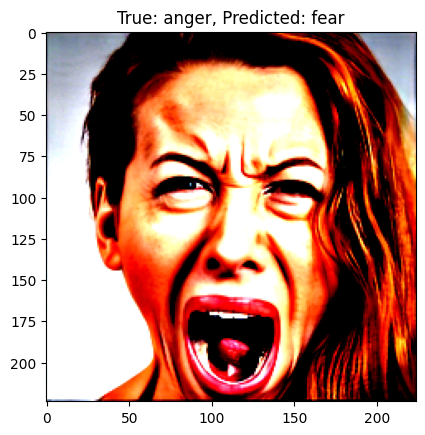

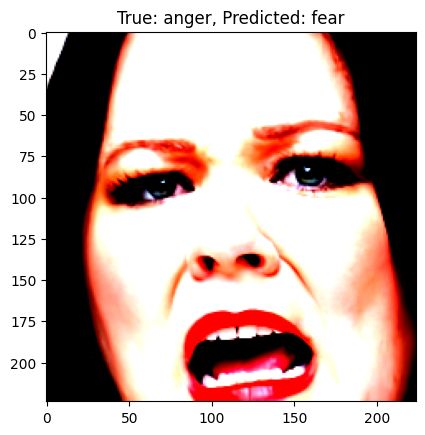

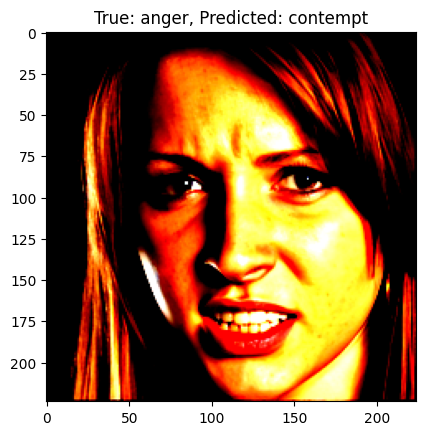

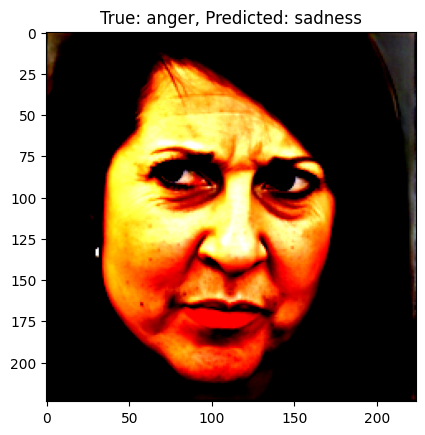

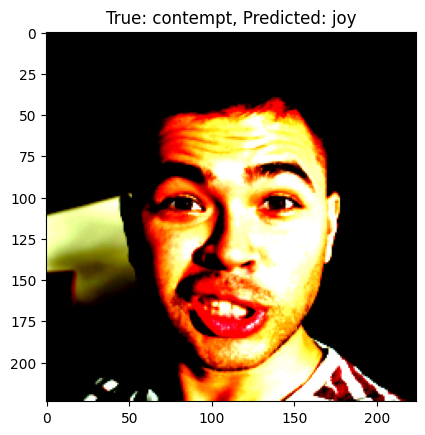

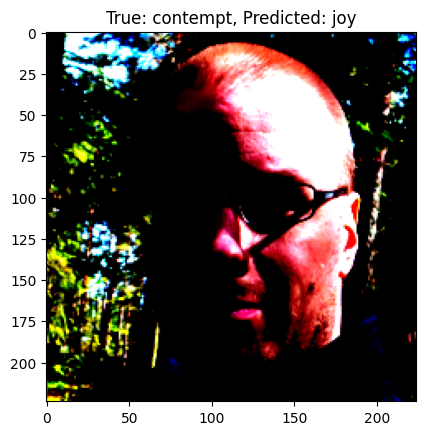

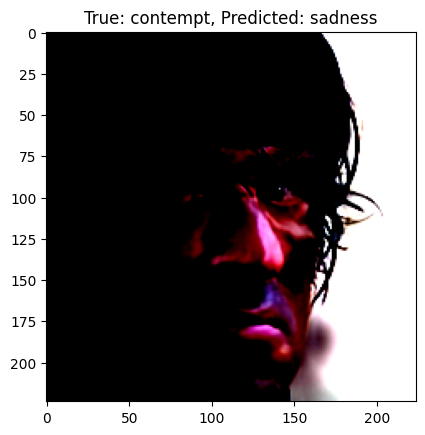

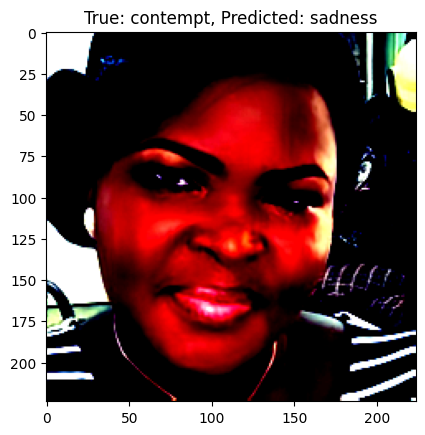

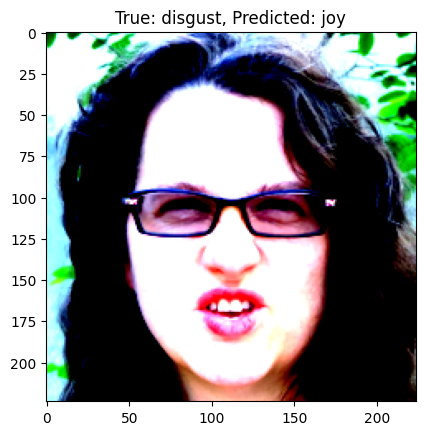

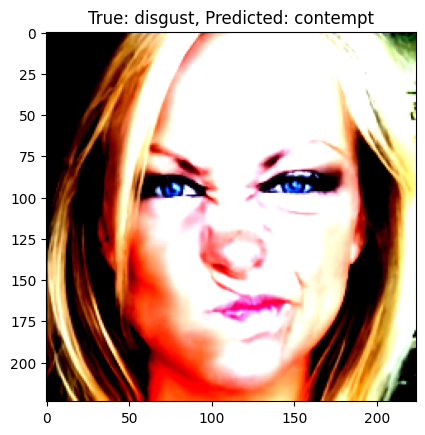

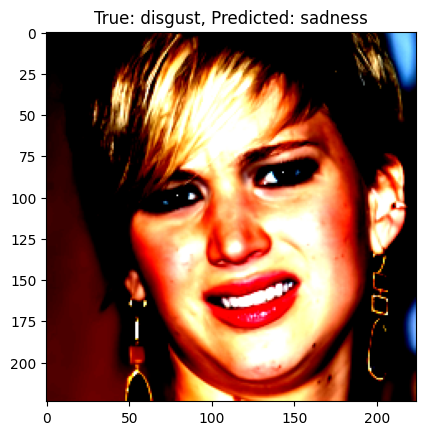

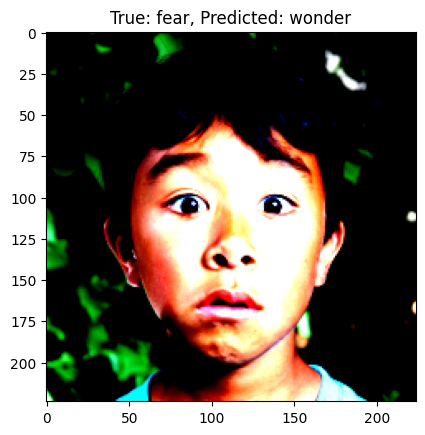

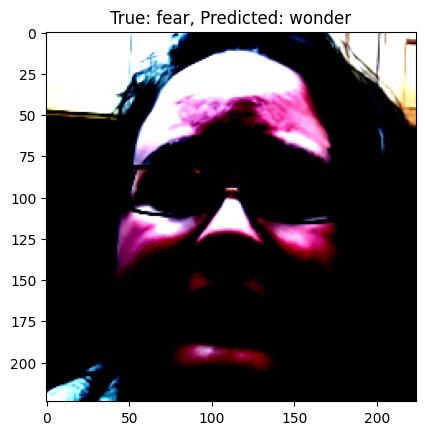

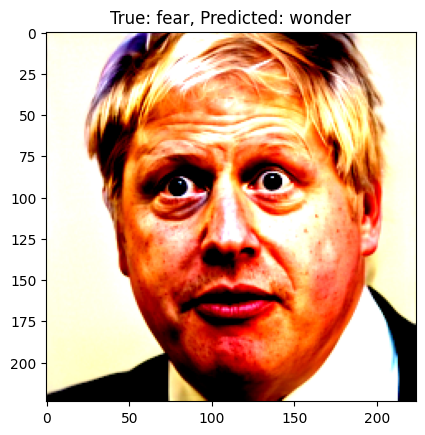

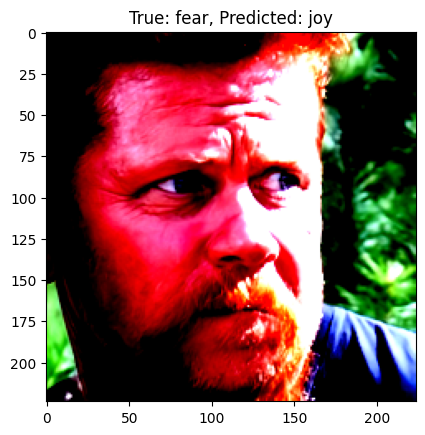

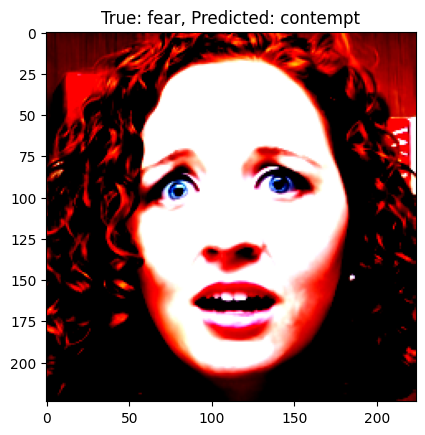

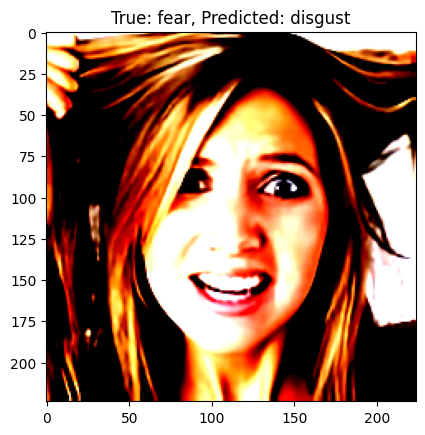

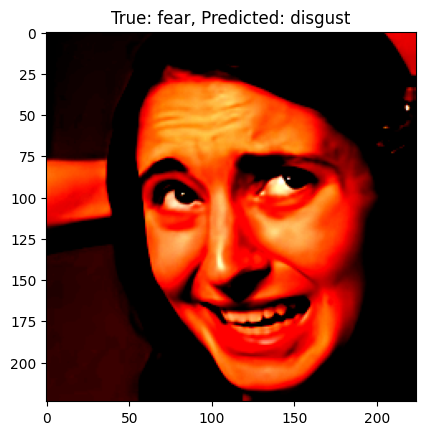

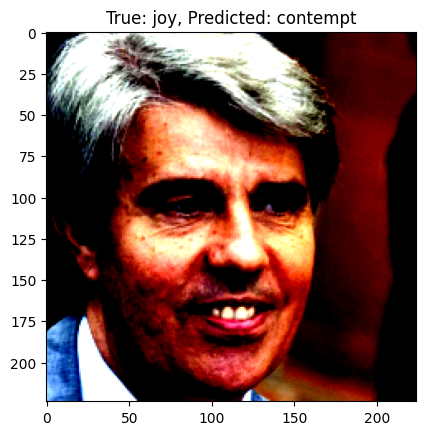

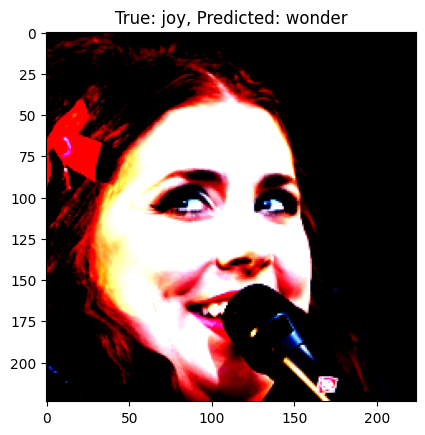

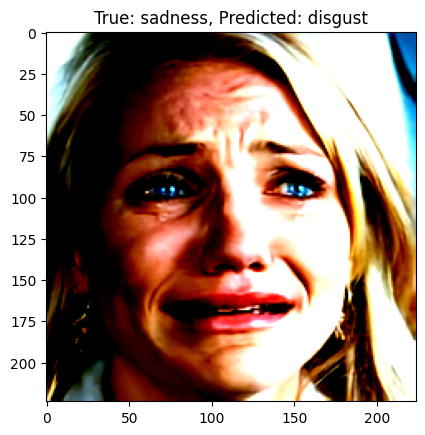

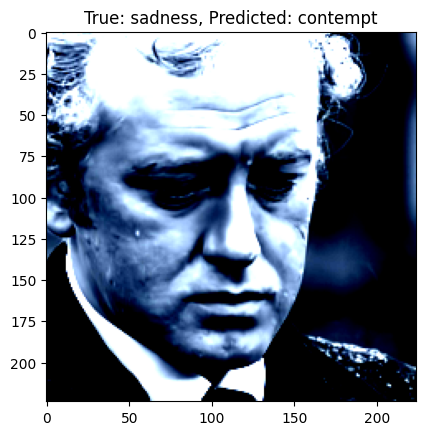

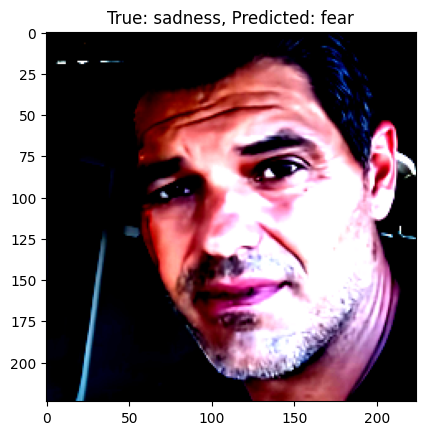

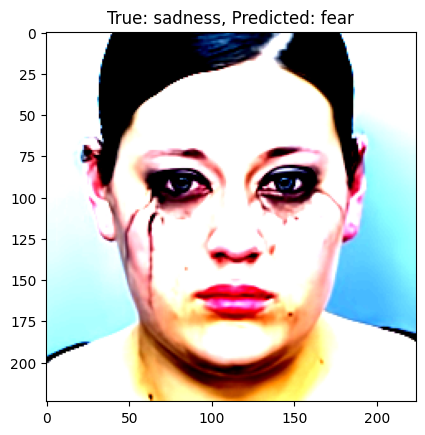

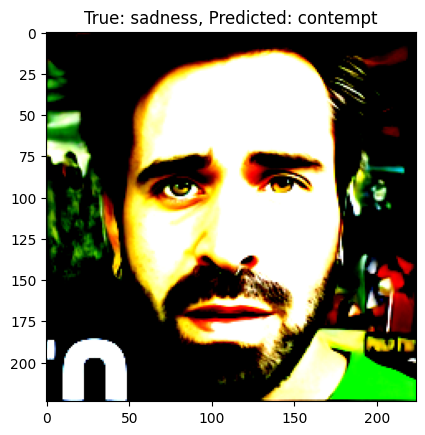

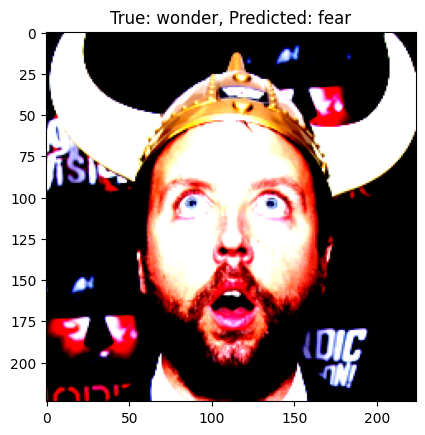

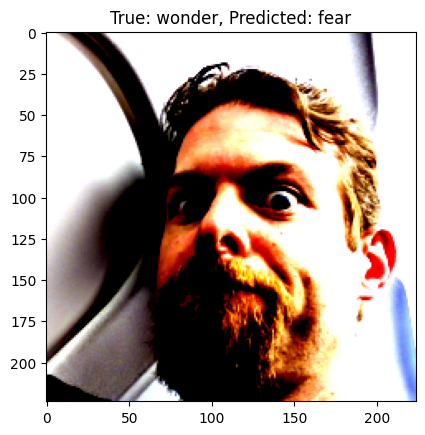

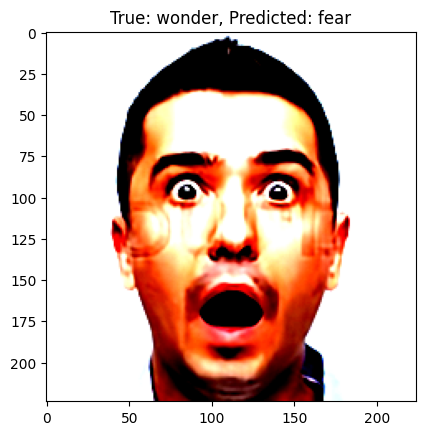

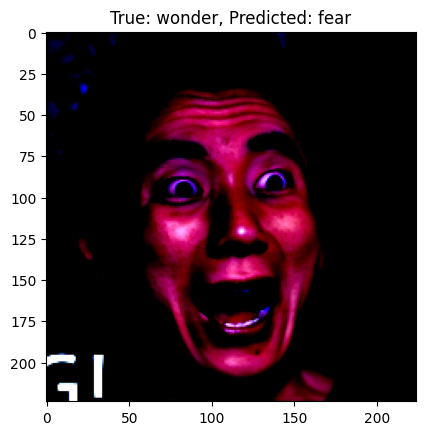

In [66]:
get_mistaken_images_report(f"{TO_LOAD_PATH}/test", pred)